In [1]:
import pandas as pd 
from datasets import load_dataset
from underthesea import sent_tokenize
import os
from tqdm import tqdm

def split_text_into_chunks(text, chunk_size=512):
    sentences = sent_tokenize(text)
    # sentences = text.split("\n")

    chunks = [sentences[0]]
    for string in sentences[1:]:
        current_length = len(chunks[-1].split())
        if current_length + len(string.split()) > chunk_size:
            chunks.append(string)
        else:
            chunks[-1] += "\n" + string

    # chunks = [tokenize(chunk) for chunk in chunks]
    return chunks

def split_text_into_chunks(text, chunk_size=100, window_size=50):
    words = text.split()
    num_words = len(words)
    chunks = []
    start_idx = 0

    while True:
        end_idx = start_idx + chunk_size
        chunk = " ".join(words[start_idx:end_idx])
        chunks.append(chunk)
        if end_idx >= num_words:
            break
        start_idx += window_size

    return chunks

corpus = []
meta_corpus = []
data_dir = "data_raw10k/"
filenames = os.listdir(data_dir)
filenames = sorted(filenames)

_id = 0
docs = {}
for filename in tqdm(filenames):
    filepath = data_dir + filename
    title = filename.strip(".txt")
    with open(filepath, "r") as f:
        text = f.read()
        docs[title] = text
        text = text.lstrip(title).strip()
        # chunks = split_text_into_chunks(text, chunk_size=150)
        chunks = split_text_into_chunks(text, chunk_size=150, window_size=150)
        chunks = [f"Title: {title}\n\n{chunk}" for chunk in chunks]
        meta_chunks = [{
            "title": title,
            "passage": chunks[i],
            "id": _id + i,
            "len": len(chunks[i].split())
        } for i in range(len(chunks))]
        _id += len(chunks)
        corpus.extend(chunks)
        meta_corpus.extend(meta_chunks)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 6773.82it/s]


In [60]:
sorted_corpus = sorted(meta_corpus, key=lambda x: x["len"])

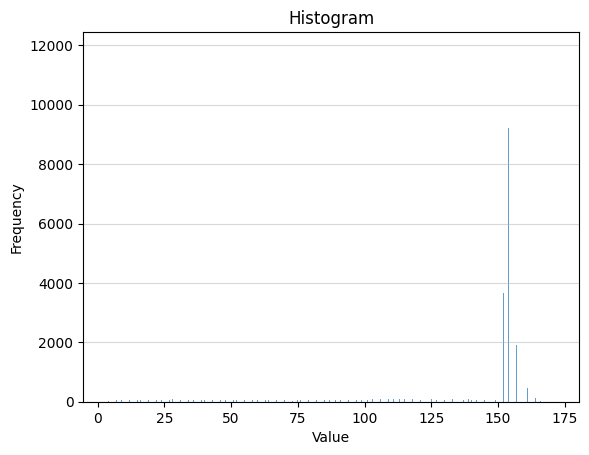

In [2]:
import matplotlib.pyplot as plt

def plot_histogram(data):
    plt.hist(data, bins='auto', alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.5)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram')
    plt.show()
lens = [x["len"] for x in meta_corpus]
plot_histogram(lens)

## Retrieve

In [3]:
pipeline = \
"""
1. query -- (keywords) --> AND & OR docs.
2. if AND docs exist, select. if not, go for OR docs. else, go for all.
   => chunking selected docs to passages --> corpus
3. retrieve from corpus. First BM25 get top 200, 
   then rerank using i) keywords matching score and ii) embedding.
   => get top 3. 
4. expand contexts
5. prompt -> generate.
""" 

## Step 1

In [4]:
important_keywords = load_dataset("json", data_files="important_keywords_4.jsonl", split="train").to_list()

In [22]:
import unicodedata as ud
import re

def delete_leading_number(string):
    pattern = r"^\d+"  # Regular expression pattern to match the desired patterns
    return re.sub(pattern, "", string)
    
def parse_keywords(example):
    question = example["question"]
    key_string = example["key_string"]
    keywords = []
    terms = key_string.split("\n")
    terms = [j.strip() for i in terms for j in i.split(",")]

    ## normalize
    question = ud.normalize("NFC", question).lower()
    terms = [ud.normalize("NFC", term).lower() for term in terms]
    for term in terms:
        term = term.strip('"').strip("'")
        term = delete_leading_number(term)
        
    ## filter 
    terms = [term for term in terms if (term.strip() and term in question)]
    terms = list(set(terms))
    return terms

In [23]:
import copy
import unicodedata as ud
import re
from tqdm import tqdm

ldocs = copy.deepcopy(docs)
ldocs = {title: ud.normalize("NFC", copy.deepcopy(doc)).lower() 
         for title, doc in ldocs.items()}
question_to_titles = copy.deepcopy(important_keywords)

for example in tqdm(question_to_titles):
    question = example["question"]
    keywords = parse_keywords(example)
    AND_docs = []
    OR_docs = []
    for title, ldoc in ldocs.items():
        if keywords and all(key in ldoc for key in keywords):
            AND_docs.append(title)
        if keywords and any(key in ldoc for key in keywords):
            OR_docs.append(title)
            
    example["keywords"] = keywords
    example["AND_docs"] = AND_docs
    example["OR_docs"] = OR_docs

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:11<00:00, 17.18it/s]


## Step 2

In [37]:
for example in tqdm(question_to_titles):
    selected_titles = "ALL"
    if len(example["OR_docs"]) > 0: 
        selected_titles = example["OR_docs"]
    if len(example["AND_docs"]) > 0: 
        selected_titles = example["AND_docs"]
        
    selected_passages_ids = [x["id"] for x in meta_corpus]
    if selected_titles != "ALL":
        selected_passages_ids = \
            [x["id"] for x in meta_corpus 
             if x["title"] in selected_titles]
    example["selected_passages_ids"] = selected_passages_ids

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 18.91it/s]


## Step 3

In [200]:
from rank_bm25 import BM25Okapi
from tqdm import tqdm
import string

def get_keyword_score(passage, keywords):
    keywords = [ud.normalize("NFC", word).lower() for word in keywords]
    passage = ud.normalize("NFC", passage).lower()
    matched_keywords = [word for word in keywords if word in passage]
    
    keywords_to_weights = {key: len(key) for key in keywords}
    numer = sum([keywords_to_weights[key] for key in matched_keywords])
    denom = sum(keywords_to_weights.values())
    if denom != 0: score = float(numer/denom)
    else: score = 0
    return score

def rerank_3_stages(passages, topk=5):
    ## BM25
    bm25_passages = sorted(selected_passages, key=lambda x: x["bm25_score"], reverse=True)[:200]
    max_bm25_score = bm25_passages[0]["bm25_score"]
    min_bm25_score = bm25_passages[-1]["bm25_score"]
    norm_bm25 = lambda x: (x - min_bm25_score + 0.1) / (max_bm25_score - min_bm25_score + 0.1)
    ## keywords + semantic
    for passage in bm25_passages:
        passage["bm25_normed_score"] = norm_bm25(passage["bm25_score"])
        passage["combined_score"] = passage["bm25_normed_score"] * 0.1 + \
                                    passage["keyword_score"] * 0.4 + passage["semantic_score"] * 0.5
    sorted_passages = sorted(bm25_passages, key=lambda x: x["combined_score"], reverse=True)
    return sorted_passages[:topk]

def split_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = text.lower().split()
    words = [word for word in words if len(word.strip()) > 0]
    return words

In [143]:
tokenized_corpus = [split_text(doc["passage"]) for doc in tqdm(meta_corpus)]
bm25 = BM25Okapi(tokenized_corpus)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 48532/48532 [00:03<00:00, 13393.52it/s]


In [144]:
# import torch 
# corpus_embs = torch.load("data/corpus_embeddings_w150.pt", map_location=torch.device('cpu'))
# questions_embs = torch.load("data/private_questions_embeddings.pt", map_location=torch.device('cpu'))
# semantic_scores = questions_embs @ corpus_embs.T

In [194]:
import pickle
with open('data/corpus_embedding_w150.pkl', 'rb') as f:
    corpus_embs = pickle.load(f)
with open('data/private_questions_embeddings.pkl', 'rb') as f:
    questions_embs = pickle.load(f)
semantic_scores = questions_embs @ corpus_embs.T

In [181]:
# max_idx = sematic_scores[-1].argmax()
# example = question_to_titles[-1]
# print(example["question"])
# print(corpus[max_idx])

In [201]:
from copy import deepcopy
for i in tqdm(range(len(question_to_titles))):
    example = question_to_titles[i]
    selected_passages_ids = example["selected_passages_ids"]
    selected_passages = [deepcopy(meta_corpus[i]) for i in selected_passages_ids]
    
    tokenized_query = split_text(example["question"])
    bm25_scores = bm25.get_scores(tokenized_query)
    
    selected_bm25_scores = bm25_scores[selected_passages_ids]
    selected_semantic_scores = semantic_scores[i][selected_passages_ids]
    for passage in selected_passages:
        passage["keyword_score"] = get_keyword_score(passage["passage"], example["keywords"])
    for passage, score in zip(selected_passages, selected_bm25_scores):
        passage["bm25_score"] = float(score)
    for passage, score in zip(selected_passages, selected_semantic_scores):
        passage["semantic_score"] = float(score)
    sorted_passages = rerank_3_stages(selected_passages)
    example["sorted_passages"] = sorted_passages

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:54<00:00,  3.65it/s]


In [219]:
example = question_to_titles[34]
print(example["question"])
print(example["keywords"])
example["sorted_passages"]

Hãy liệt kê các chức vụ trong sự nghiệp chính trị của bà Nguyễn Thị Kim Ngân, nguyên chủ tich quốc hội nước Việt Nam ?
['bà nguyễn thị kim ngân']


[{'title': 'Nguyễn Thị Kim Ngân',
  'passage': 'Title: Nguyễn Thị Kim Ngân\n\nQuốc hội khóa 14. Chủ tịch Quốc hội. Tại Đại hội Đại biểu toàn quốc Đảng Cộng sản Việt Nam lần thứ XII, bà tiếp tục được bầu lại vào Ban Chấp hành Trung ương Đảng, được Ban Chấp hành Trung ương bầu vào Bộ Chính trị. Tại kỳ đại hội này, bà cũng được đề cử vào vị trí Chủ tịch Quốc hội. Ngày 31 tháng 3 năm 2016, Phó chủ tịch Quốc hội Nguyễn Thị Kim Ngân tuyên thệ nhậm chức Chủ tịch Quốc hội khóa XIII (2011-2016) thay ông Nguyễn Sinh Hùng. Sáng ngày 22 tháng 7 năm 2016, bà Nguyễn Thị Kim Ngân được các đại biểu Quốc hội Việt Nam khóa 14 bầu làm Chủ tịch Quốc hội Việt Nam khóa 14 với tỉ lệ 483/489 phiếu thuận (tổng 490 phiếu, 1 phiếu không hợp lệ). Trong nhiệm kì của bà, Quốc hội Việt Nam',
  'id': 26520,
  'len': 155,
  'keyword_score': 1.0,
  'bm25_score': 51.91826831648119,
  'semantic_score': 0.690834641456604,
  'bm25_normed_score': 0.9054914305320971,
  'combined_score': 0.8359664637815117},
 {'title': 'Nguyễ

## Step 4

In [265]:
def expand_context(passage, word_window=40):
    psg_id = passage["id"]
    title = passage["title"]
    prev_id = psg_id - 1
    next_id = psg_id + 1
    strip_title = lambda x: x["passage"].strip(f"Title: {x['title']}\n\n")
    
    texts = []
    if prev_id in range(0, len(meta_corpus)):
        prev_psg = meta_corpus[prev_id]
        if prev_psg["title"] == title: 
            prev_text = strip_title(prev_psg)
            prev_text = " ".join(prev_text.split()[-word_window:])
            texts.append(prev_text)
            
    texts.append(strip_title(passage))
    
    if next_id in range(0, len(meta_corpus)):
        next_psg = meta_corpus[next_id]
        if next_psg["title"] == title: 
            next_text = strip_title(next_psg)
            next_text = " ".join(next_text.split()[:word_window])
            texts.append(next_text)

    expanded_text = " ".join(texts)
    expanded_text = f"Title: {title}\n{expanded_text}"
    return expanded_text
    

In [271]:
for example in tqdm(question_to_titles):
    sorted_passages = example["sorted_passages"]
    expanses = [expand_context(p) for p in sorted_passages]
    context = "\n".join([f"Context [{i+1}] : {expanded}" 
                         for i, expanded in enumerate(expanses[:3])])
    example["full_context"] = context

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 8898.11it/s]


## Step 5. Genrerate prompt

In [275]:
import unicodedata as ud
from enum import Enum
from typing import Generator, Optional, Union
class PromptStyle(Enum):
    """
    Enum for prompt styles
    """

    INSTRUCT = "instruct"
    CHAT = "chat"
    CHATML = "chatml"

class AlpacaPrompter:
    """
    Base class for alpaca prompters
    """

    system_prompt = "Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n"
    system_no_input_prompt = "Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n"
    system_format: str = "{system}"
    turn_format: str
    turn_no_input_format: str
    prompt_style: Optional[PromptStyle] = None

    def __init__(self, prompt_style=PromptStyle.INSTRUCT.value):
        self.prompt_style = prompt_style if prompt_style else PromptStyle.INSTRUCT.value
        self.match_prompt_style()

    def match_prompt_style(self):
        # pylint: disable=duplicate-code
        if self.prompt_style == PromptStyle.INSTRUCT.value:
            self.turn_format = "### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Response:\n"
            self.turn_no_input_format = (
                "### Instruction:\n{instruction}\n\n### Response:\n"
            )
            self.system_format = "### System:\n{system}\n\n"
        if self.prompt_style == PromptStyle.CHAT.value:
            self.turn_format = "USER: {instruction}\n{input}\nASSISTANT:"
            self.turn_no_input_format = "USER: {instruction}\nASSISTANT:"
            self.system_format = "SYSTEM: {system}\n"
        if self.prompt_style == PromptStyle.CHATML.value:
            self.turn_format = "<|im_start|>user\n{instruction}\n{input}<|im_end|>\n<|im_start|>assistant\n"
            self.turn_no_input_format = (
                "<|im_start|>user\n{instruction}<|im_end|>\n<|im_start|>assistant\n"
            )
            self.system_format = "<|im_start|>system\n{system}<|im_end|>\n"

    def build_prompt(
        self,
        instruction: str,
        input: Union[None, str] = None,  # pylint: disable=redefined-builtin
        output: Union[None, str] = None,
    ) -> Generator[str, None, None]:
        # returns the full prompt from instruction and optional input
        # if a label (=response, =output) is provided, it's also appended.
        if input:
            res = (
                self.system_format.format(system=self.system_prompt)
                if self.system_prompt
                else ""
            ) + self.turn_format.format(instruction=instruction, input=input)
        else:
            res = (
                self.system_format.format(system=self.system_no_input_prompt)
                if self.system_prompt
                else ""
            ) + self.turn_no_input_format.format(instruction=instruction)
        if output:
            res = f"{res}{output}"
        yield res
prompter = AlpacaPrompter(prompt_style=PromptStyle.INSTRUCT.value)
def gen_prompt(question, context):
    question = ud.normalize("NFC", question)
    context = ud.normalize("NFC", context)
    instruction = 'As an intelligent AI model, your task is to analyze and integrate information from multiple contexts given below in order to answer questions and provide citations. Only use the information provided in the context to select the most relevant sentences to the question.'  
    input = f"Provide answer to the question at the end based on the following retrieved contexts, don't give false information and filter some unnecessary information.\n{context}\nQuestion: {question}\nAnswer:"
    prompt = prompter.build_prompt(instruction=instruction, input=input, output="").__next__()
    return prompt

In [277]:
## Generate and save prompts
import json
from tqdm import tqdm
from copy import deepcopy
with open("data/prompts_v2.jsonl", "w") as file:
    for example in tqdm(question_to_titles):
        question = example.get("question")
        context = example.get("full_context")
        prompt = gen_prompt(question, context)
        file.write(json.dumps({"prompt": prompt}, ensure_ascii=False) + "\n")
        # print(question)
        # answer = get_answer(prompt, max_new_tokens=1024)
        # example["answer"] = answer
        # print("---" * 30)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 18523.21it/s]
